In [197]:
# Mount google drive
# Uncomment this if I am running on google collab
# from google.colab import drive
# drive.mount('/content/sta365_hw3')

Drive already mounted at /content/sta365_hw3; to attempt to forcibly remount, call drive.mount("/content/sta365_hw3", force_remount=True).


In [ ]:
# If using google collab, use this first path. 
# path = "sta365_hw3/MyDrive/STA365/HW3/prices.csv"

# if running locally, use this path instead
path = "prices.csv"

In [198]:
# Import libraries
import pymc as pm

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from scipy import stats


# Step 0 & 2 (Choosing data set, normal data, and non-normal data)

I've chosen the dataset "Vegetable Prices" from Kaggle. (https://www.kaggle.com/datasets/ksamiksha19/vegetable-prices/data)

I've explored some of the data initially, plotting out potato, garlic, green chilli, and onion prices' histogram.

After looking at the data distribution, I decided to proceed with Green Chilli for the normal-gamma inference, and the Onion Prices to model for an exponential-gamma interence.

Since Green Chilli's data resembles a normal distribution (From the Orange Line I have plotted with an eye-balled parameter) I am fairly confident to believe that Green Chilli Prices has a likelihood resembling a normal distribution.

From the Onion Prices' histogram, I see that it resembles an exponential distribution (Similarily from the orange line), I believe that the Onion Prices liklelihood follow an exponential distribution.

Note that the "scale" in stats.expon follows the value $scale=1/lambda$ instead of lambda itself.

In [199]:
raw_data = pd.read_csv(path)
print(raw_data.keys())


Index(['Price Dates', 'Bhindi (Ladies finger)', 'Tomato', 'Onion', 'Potato',
       'Brinjal', 'Garlic', 'Peas', 'Methi', 'Green Chilli',
       'Elephant Yam (Suran)'],
      dtype='object')


In [200]:
potato_prices = raw_data["Potato"]
garlic_prices = raw_data["Garlic"]
gr_chilli_prices = raw_data["Green Chilli"]
onion_prices = raw_data["Onion"]

Text(0.5, 1.0, 'Onion Prices')

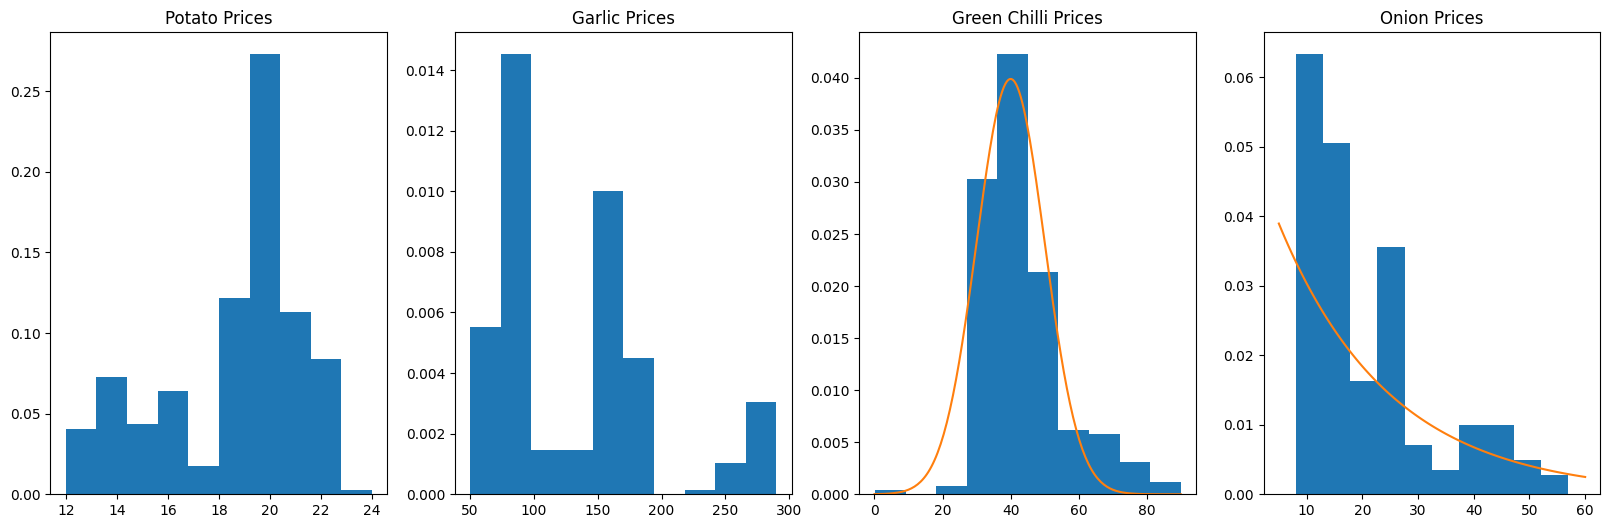

In [201]:
fig, ax = plt.subplots(1, 4, figsize=(20,6))

gc_theta_0 = 40
gc_tau = 10
gr_chilli_normal = stats.norm(loc=gc_theta_0, scale = gc_tau)
gc_rpm = np.linspace(0, 90, 200)

onion_theta_0 = 0
onion_tau = 1/0.05
onion_exponential = stats.expon(loc=onion_theta_0, scale=onion_tau)
onion_rpm = np.linspace(5, 60, 100)


ax[0].hist(potato_prices, density=True)
ax[0].set_title("Potato Prices")
ax[1].hist(garlic_prices, density=True)
ax[1].set_title("Garlic Prices")

ax[2].hist(gr_chilli_prices, density=True)
ax[2].plot(gc_rpm, gr_chilli_normal.pdf(gc_rpm))
ax[2].set_title("Green Chilli Prices")

ax[3].hist(onion_prices, density=True)
ax[3].plot(onion_rpm, onion_exponential.pdf(onion_rpm))
ax[3].set_title("Onion Prices")

# Step 1: Normal-Gamma specification

Mentioned above, I chose to model the Green Chilli prices using normal-gamma specification.

Here I used pymc and had a normal distribution for theta, and a Gamma distribution for phi.

And my likelihood follows a Normal Distribution.

Then, in the next codeblock, I let pymc auto sample.

In [202]:
# use pymc on green chilli prices to model a normal-gamma distribution

gr_chilli_normal_gamma_model = pm.Model()

with gr_chilli_normal_gamma_model:
    theta = pm.Normal("theta", mu=40, sigma=5)
    phi = pm.Gamma("phi", alpha=2, beta=1)
    x_obs_chilli = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=gr_chilli_prices)


In [203]:
with gr_chilli_normal_gamma_model:
    chilli_HMC = pm.sample(init='auto')

# Step 3 Non Normal Specification (Exponential-Gamma specification)

Mentioned above, I chose to explore the Onion Prices that seems to follow an exponential distribution.

Therefore, I created a PYMC specification using Exponential Distribution as my likelihood, and a Gamma dsitribution as my lambda.

In [204]:
# use pymc on onion prices to model a exponential distribution

onion_expon_gamma_model = pm.Model()

with onion_expon_gamma_model:
    lambda_onion = pm.Gamma('lambda', alpha=2, beta=1)
    x_obs_onion = pm.Exponential('likelihood', lam=lambda_onion, observed=onion_prices)


In [205]:
with onion_expon_gamma_model:
    onion_HMC = pm.sample()

HMC Split-Rhats Green Chilli {'theta': 1.0051, 'phi': 1.0002}
HMC Split-Rhats Onion {'lambda': 1.0054}


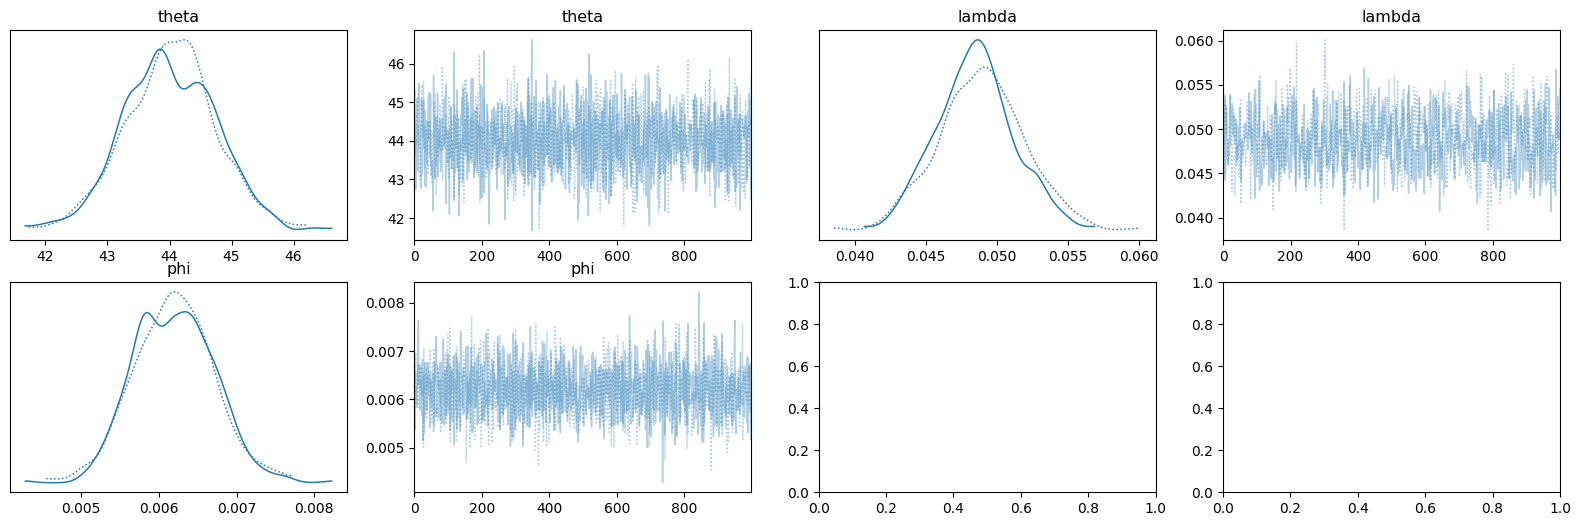

In [206]:
import arviz as az
fig,ax = plt.subplots(2,4, figsize=(20,6))
az.plot_trace(chilli_HMC, axes=ax[:2,:2])
az.plot_trace(onion_HMC, axes=ax[:2,2:])
print("HMC Split-Rhats Green Chilli", {k: np.round(v.values,4) for k,v in az.rhat(chilli_HMC).items()})
print('HMC Split-Rhats Onion',{k: np.round(v.values,4) for k,v in az.rhat(onion_HMC).items()})

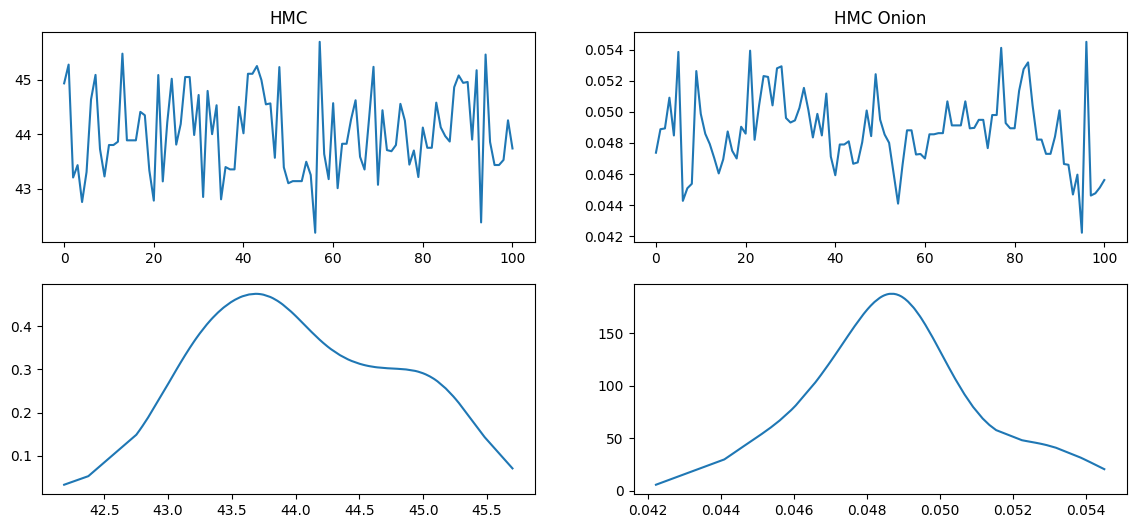

In [207]:
fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain_chilli = chilli_HMC.posterior["theta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_chilli_sorted = sorted(mcmc_chain_chilli)
ax[0,0].plot(mcmc_chain_chilli)
ax[1,0].plot(mcmc_chain_chilli_sorted,stats.gaussian_kde(mcmc_chain_chilli_sorted)(mcmc_chain_chilli_sorted))
ax[0,0].set_title("HMC");

mcmc_chain_onion = onion_HMC.posterior["lambda"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values
mcmc_chain_onion_sorted = sorted(mcmc_chain_onion)
ax[0,1].plot(mcmc_chain_onion)
ax[1,1].plot(mcmc_chain_onion_sorted,stats.gaussian_kde(mcmc_chain_onion_sorted)(mcmc_chain_onion_sorted))
ax[0,1].set_title("HMC Onion");

Autocorrelation for HMC (MCMC) chain -0.040212858464825314
Autocorrelation for HMC (MCMC) chain For Onion 0.35420962657430016


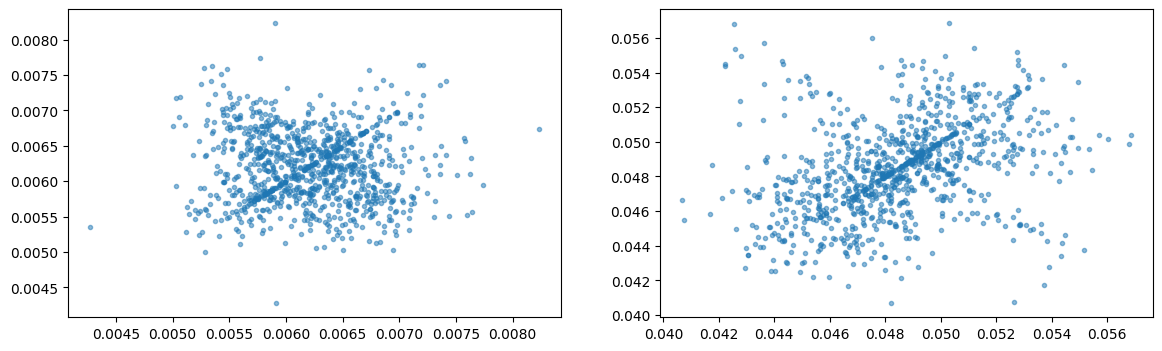

In [208]:
fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000

# Green Chilli Prices
mcmc_chain_chilli = chilli_HMC.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_chilli_one_step_ahead = chilli_HMC.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax[0].plot(mcmc_chain_chilli, mcmc_chain_chilli_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain_chilli,mcmc_chain_chilli_one_step_ahead)[0,1])

# Onion Prices
mcmc_chain_onion = onion_HMC.posterior["lambda"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_onion_one_step_ahead = onion_HMC.posterior["lambda"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
ax[1].plot(mcmc_chain_onion, mcmc_chain_onion_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain For Onion", np.corrcoef(mcmc_chain_onion, mcmc_chain_onion_one_step_ahead)[0,1])

In [209]:
print("number of MCMC samples:", chilli_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(chilli_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,44.01,0.73,42.62,45.36,0.02,0.01,2044.19,1220.22,1.01
phi,0.01,0.00,0.01,0.01,0.00,0.00,2300.11,1667.47,1.00


In [210]:
print("number of MCMC samples for Onion Prices:", onion_HMC.posterior['lambda'].values.flatten().shape[-1])
az.summary(onion_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html

number of MCMC samples for Onion Prices: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,0.05,0.0,0.04,0.05,0.0,0.0,842.85,1323.39,1.01


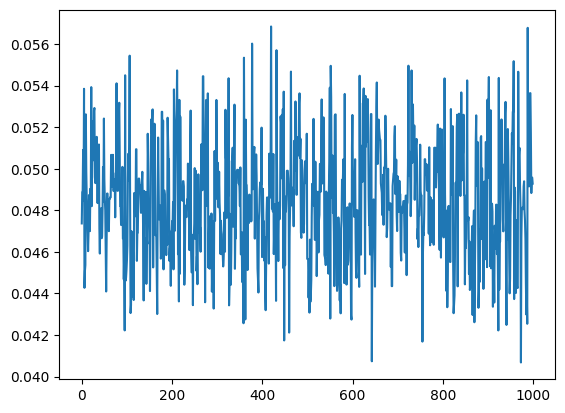

In [226]:
# Verify if tthe samples move back and fourth within tails and not tails

x_axis = np.linspace(0, mcmc_chain_onion.shape[0], mcmc_chain_onion.shape[0])

plt.figure()
plt.plot(x_axis, mcmc_chain_onion)


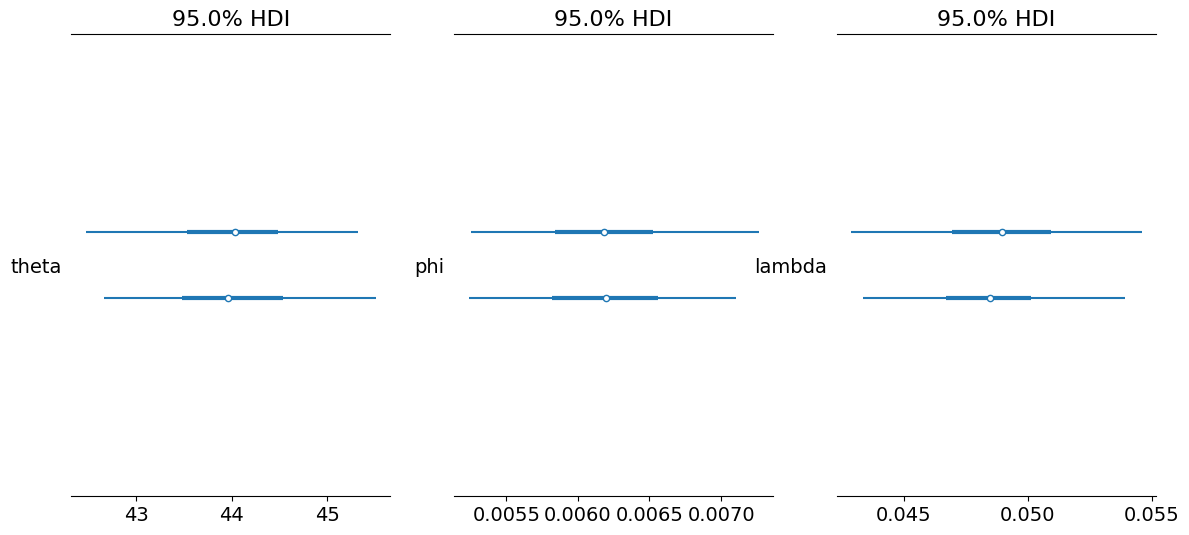

In [211]:
fig,ax = plt.subplots(1,3, figsize=(14,6))
az.plot_forest(chilli_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(chilli_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1])
az.plot_forest(onion_HMC, var_names=["lambda"], combined=False, hdi_prob=0.95, ax=ax[2])

# Step 1 & 4 (Making Posterior Inferences)

After running sample on PYMC, and from the outputs and graphs above, we can come to these conclusions:

Firstly, analyzing the Green Chilli Prices.

We see that the Split-R-hat value is < 1.05, which means that the values seems to agree by not failing the similarity test.

We also see a slightly negative autocorrelation, but the value is close to 0.

The ess_bulk and ess_tail values are also meaningful as we see that the negative autocorrelation allows us to obtain a slightly larger effective sample size than what we have sampled using PYMC.


Finally, using all the information above, I believe that the credible interval for this simulation is reliable. And generating the credible intervals above,  the theta and phi 95% credible intervals tells us that we are 95% confident that the theta is somewhere around 44, and the phi is somewhere around 0.006.

Translating this to the mean and variance that we have seen in my initial graphs of the distribution, we can confirm that is it likely true since the orange normal distribution line I have graphs that somewhat resembles the data has a mean of 40 and variance = $1/phi^{0.5}$ => $1/0.006^{0.5} ≈ 12.9$ and these values are close to the plotted normal distribution.


Lets look at the Onion Prices now.

We see that the Split-R-hat value is also < 1.05, so we see that the sample does not fail the similarity test.

We do see a larger autocorrelation, however. But with an autocorrelation value of 0.3, I think it is still acceptable as it is not too correlated to the extent that it affects the effective sample size.

From the ess_bulk and ess_tail, we do see some potential issues as the ess_bulk value is less than ess_tail. This may suggest that the sampler has not yet fully explored the posterior distribution, and more samples may be required.

However, I plotted the mcmc chain values in order and I see that the sampler is moving up and down freely, and it is not only sampling larger or smaller values only. This suggests that our sampler is exploring the posterior distribution pretty well and it shows that the ess_tail and ess_bulk issue is less alarming.

With the findings above and keeping in mind of the ess_bulk value being low and the autocorrelation being somewhat bigger than expected, I produced the 95% credible interval.

From the interval, I can see that the lambda is believed to be around and slightly lower than 0.05. Plugging that back to my initial exponential distribution estimation: the scale = $1/lambda = 1/0.05 ≈ 20$

This estimated lambda closely resembles my initial plot and seems to be modeling the data pretty well.

So I think I can conclude that my inferences are relatively reliable from these findings.

These findings above for both the Green Chilli and Onion Price shows a relatively reliable inference of the posterior belief.